# EDA và Data Preprocessing cho Credit Card Fraud Detection

Notebook này thực hiện:
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing sử dụng các functions từ `src/data_preprocessing.py`


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
from pathlib import Path
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Get project root directory
# Try to find project root by looking for src directory
current_dir = Path.cwd()
project_root = current_dir

# Check if we're in notebooks directory or project root
if (current_dir / 'src').exists():
    # We're in project root
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    # We're in notebooks directory
    project_root = current_dir.parent
else:
    # Fallback: assume we're in project root
    project_root = current_dir

# Add project root to path for imports
project_root_str = str(project_root.absolute())
if project_root_str not in sys.path:
    sys.path.insert(0, project_root_str)

# Import preprocessing functions
from src.data_preprocessing import scale_features, split_data, apply_smote, get_class_weights

print(f"Current working directory: {Path.cwd()}")
print(f"Project root: {project_root.absolute()}")
print("Libraries imported successfully!")


Current working directory: d:\Code\credit_fraud_detection\notebooks
Project root: d:\Code\credit_fraud_detection
Libraries imported successfully!


## 1. Load và Kiểm tra Dữ liệu Cơ bản


In [2]:
# Load data
data_path = project_root / 'data' / 'creditcard.csv'
df = pd.read_csv(data_path)

print(f"Shape of dataset: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Shape of dataset: (284807, 31)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

First few rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Basic info
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nBasic Statistics:")
df.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 2. Kiểm tra Missing Values


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("Missing Values Found:")
    print(missing_df)
    # Visualize missing values
    plt.figure(figsize=(10, 6))
    sns.barplot(data=missing_df.reset_index(), x='index', y='Missing Percentage')
    plt.title('Missing Values by Column')
    plt.xlabel('Column')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("✓ No missing values found in the dataset!")


✓ No missing values found in the dataset!


## 3. Kiểm tra Outliers


In [5]:
# Check outliers for Amount feature using IQR method
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)]
print(f"Outliers detected using IQR method: {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.2f}%)")
print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

# Check outliers using Z-score method
from scipy import stats
z_scores = np.abs(stats.zscore(df['Amount']))
outliers_zscore = df[z_scores > 3]
print(f"\nOutliers detected using Z-score method (|z| > 3): {len(outliers_zscore)} ({len(outliers_zscore)/len(df)*100:.2f}%)")


Outliers detected using IQR method: 31904 (11.20%)
Lower bound: -101.75, Upper bound: 184.51

Outliers detected using Z-score method (|z| > 3): 4076 (1.43%)


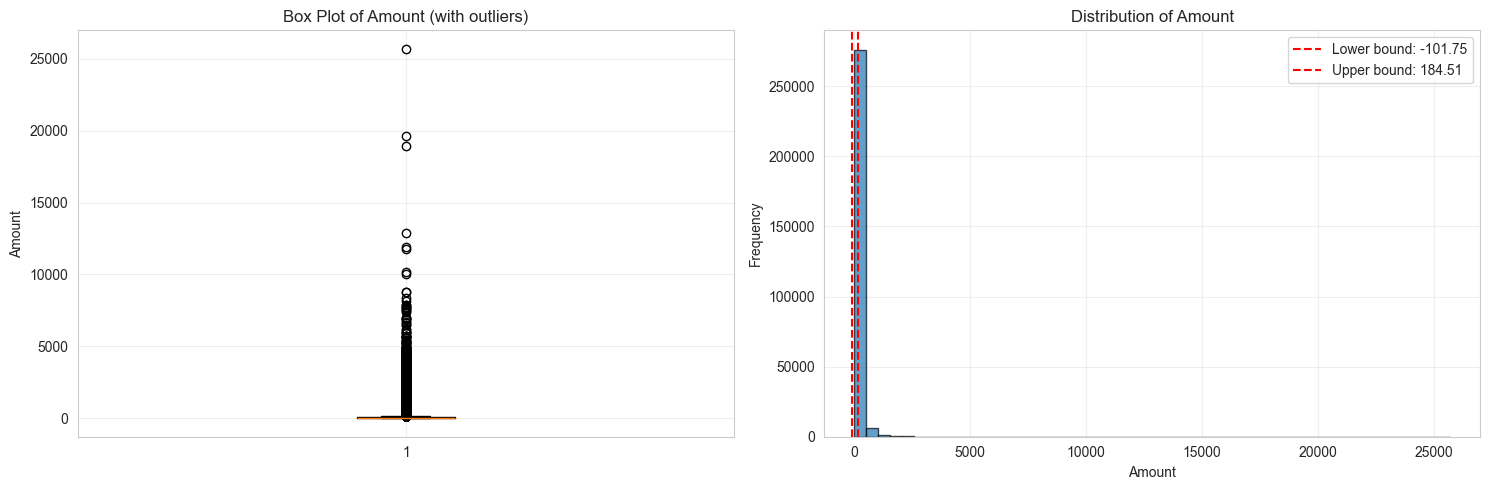

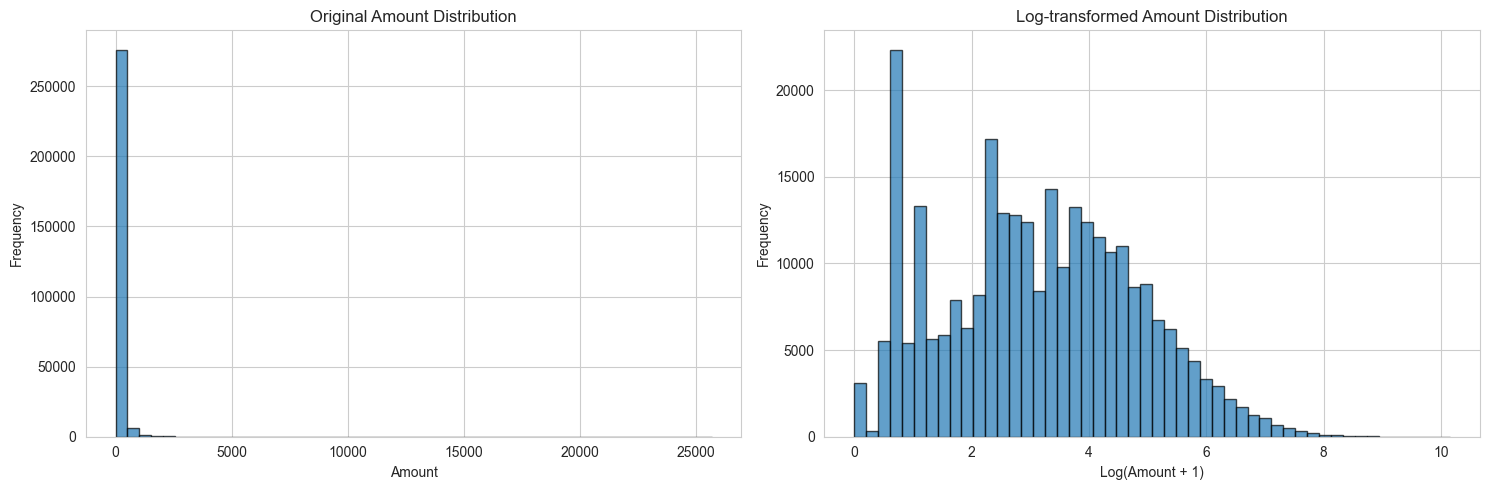

In [6]:
# Visualize outliers for Amount
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
axes[0].boxplot(df['Amount'], vert=True)
axes[0].set_title('Box Plot of Amount (with outliers)')
axes[0].set_ylabel('Amount')
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(df['Amount'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(lower_bound, color='r', linestyle='--', label=f'Lower bound: {lower_bound:.2f}')
axes[1].axvline(upper_bound, color='r', linestyle='--', label=f'Upper bound: {upper_bound:.2f}')
axes[1].set_title('Distribution of Amount')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Log transform visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original
axes[0].hist(df['Amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Original Amount Distribution')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')

# Log transformed (add small value to avoid log(0))
axes[1].hist(np.log1p(df['Amount']), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Log-transformed Amount Distribution')
axes[1].set_xlabel('Log(Amount + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## 4. Phân phối các Features


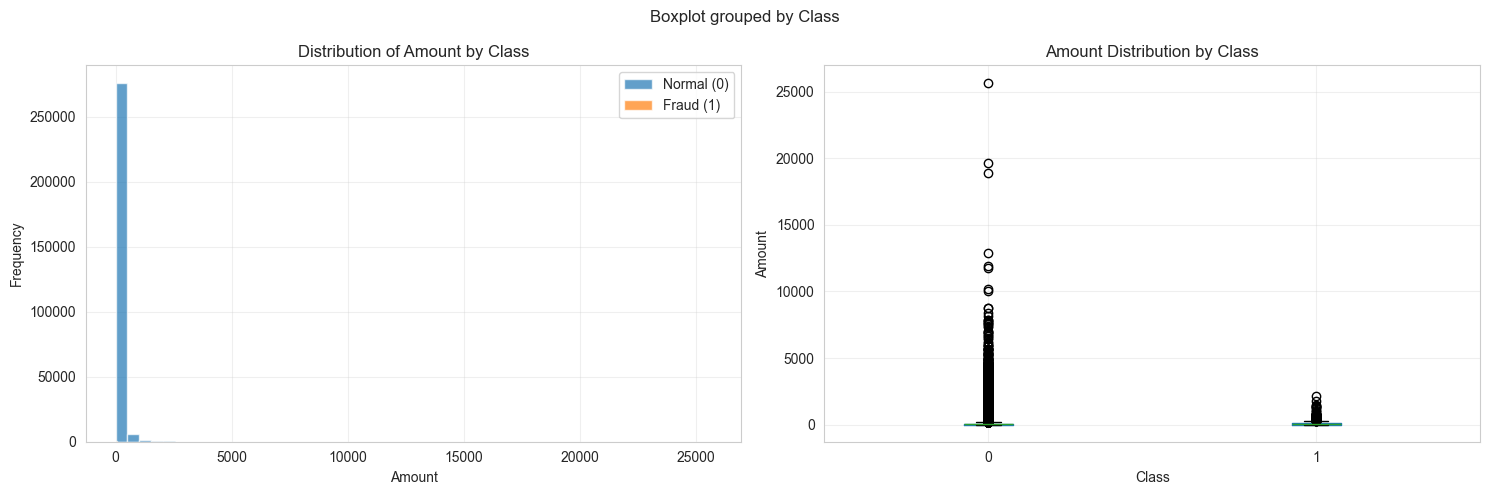

Amount Statistics by Class:
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87


In [7]:
# Distribution of Amount by Class
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
df[df['Class'] == 0]['Amount'].hist(bins=50, alpha=0.7, label='Normal (0)', ax=axes[0])
df[df['Class'] == 1]['Amount'].hist(bins=50, alpha=0.7, label='Fraud (1)', ax=axes[0])
axes[0].set_title('Distribution of Amount by Class')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
df.boxplot(column='Amount', by='Class', ax=axes[1])
axes[1].set_title('Amount Distribution by Class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Amount')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics by class
print("Amount Statistics by Class:")
print(df.groupby('Class')['Amount'].describe())


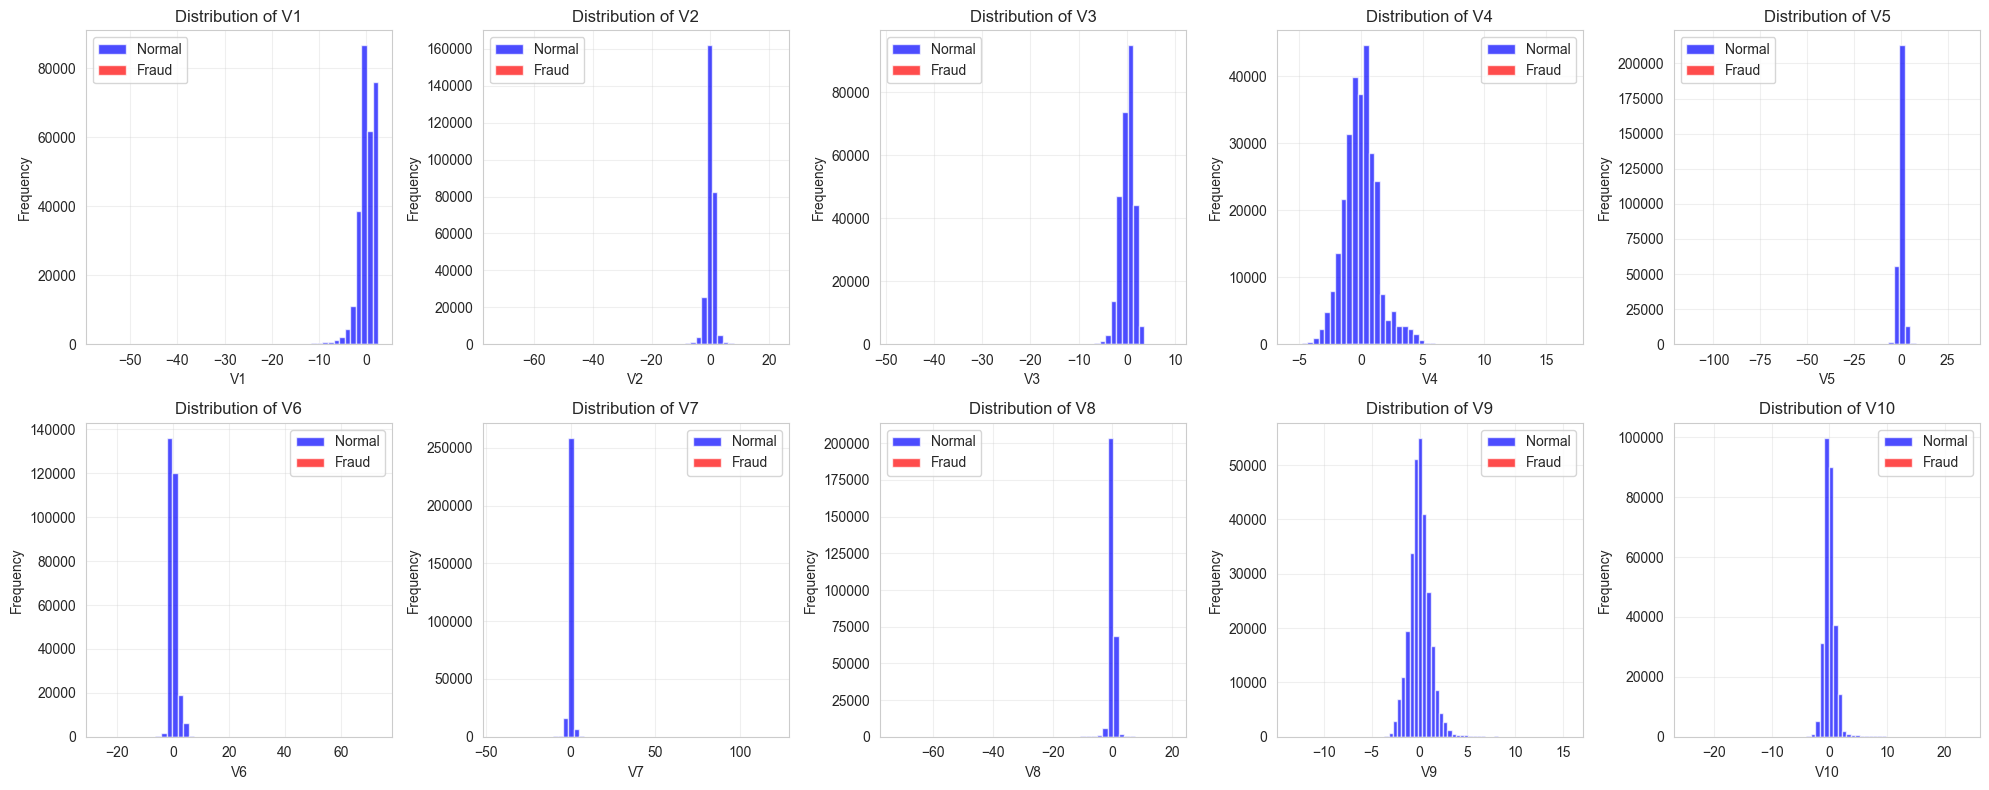

In [8]:
# Sample some V features to visualize (V1-V28 are PCA transformed)
# Let's visualize a few representative features
sample_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, feature in enumerate(sample_features):
    df[df['Class'] == 0][feature].hist(bins=50, alpha=0.7, label='Normal', ax=axes[i], color='blue')
    df[df['Class'] == 1][feature].hist(bins=50, alpha=0.7, label='Fraud', ax=axes[i], color='red')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


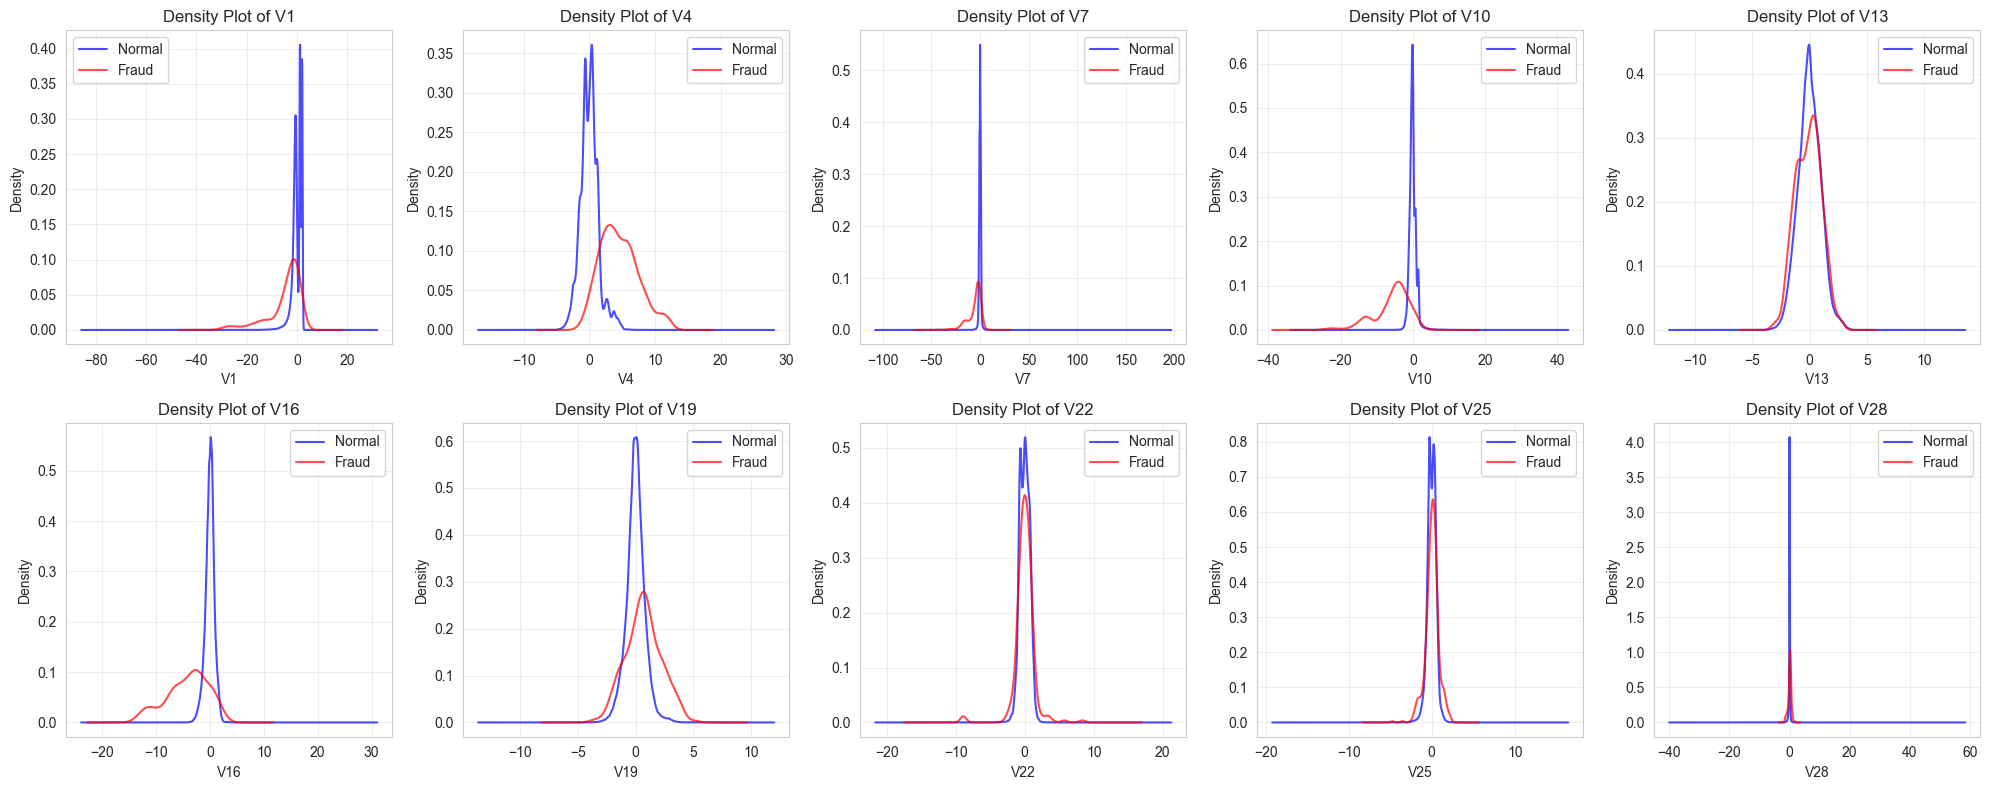

In [9]:
# Compare distributions for all V features (density plots)
v_features = [f'V{i}' for i in range(1, 29)]

# Select a subset for visualization (every 3rd feature to avoid overcrowding)
selected_v_features = v_features[::3]  # V1, V4, V7, V10, V13, V16, V19, V22, V25, V28

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, feature in enumerate(selected_v_features):
    df[df['Class'] == 0][feature].plot.density(ax=axes[i], label='Normal', color='blue', alpha=0.7)
    df[df['Class'] == 1][feature].plot.density(ax=axes[i], label='Fraud', color='red', alpha=0.7)
    axes[i].set_title(f'Density Plot of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Kiểm tra Tỉ lệ Fraud/Normal (Class Imbalance)


In [10]:
# Class distribution
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(f"Normal (0): {class_counts[0]:,} ({class_percentages[0]:.2f}%)")
print(f"Fraud (1): {class_counts[1]:,} ({class_percentages[1]:.2f}%)")
print(f"\nImbalance Ratio: {class_counts[0]/class_counts[1]:.2f}:1 (Normal:Fraud)")


Class Distribution:
Normal (0): 284,315 (99.83%)
Fraud (1): 492 (0.17%)

Imbalance Ratio: 577.88:1 (Normal:Fraud)


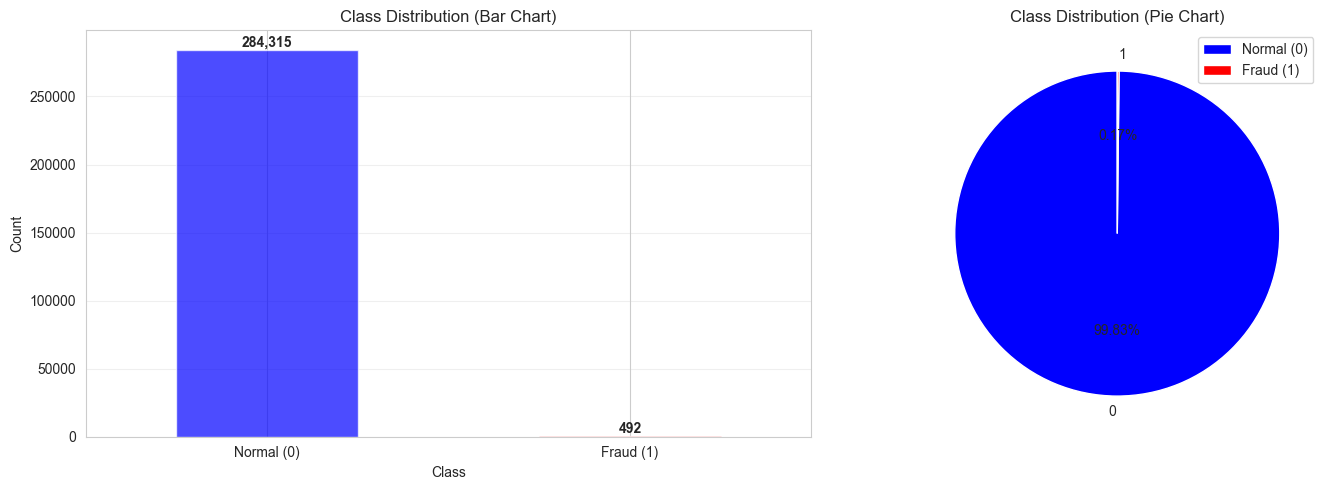


⚠️ Dataset is highly imbalanced!
This will require special handling during model training.


In [11]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart
class_counts.plot(kind='bar', ax=axes[0], color=['blue', 'red'], alpha=0.7)
axes[0].set_title('Class Distribution (Bar Chart)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Normal (0)', 'Fraud (1)'], rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(class_counts):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
class_counts.plot(kind='pie', ax=axes[1], autopct='%1.2f%%', colors=['blue', 'red'], startangle=90)
axes[1].set_title('Class Distribution (Pie Chart)')
axes[1].set_ylabel('')
axes[1].legend(['Normal (0)', 'Fraud (1)'])

plt.tight_layout()
plt.show()

print("\n⚠️ Dataset is highly imbalanced!")
print("This will require special handling during model training.")


## 6. Data Preprocessing

Sử dụng các functions từ `src/data_preprocessing.py` để thực hiện preprocessing.


In [12]:
# Prepare features and target
feature_cols = [f'V{i}' for i in range(1, 29)] + ['Amount']
X = df[feature_cols]
y = df['Class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {feature_cols[:5]}... (total {len(feature_cols)} features)")


Features shape: (284807, 29)
Target shape: (284807,)

Feature columns: ['V1', 'V2', 'V3', 'V4', 'V5']... (total 29 features)


### 6.1 Scaling Features


In [13]:
# Scale features using StandardScaler
X_scaled, scaler = scale_features(X, feature_cols=feature_cols, fit=True)

print("Features scaled successfully!")
print(f"Scaled features shape: {X_scaled.shape}")
print(f"\nScaler statistics:")
print(f"Mean: {scaler.mean_[:5]}... (showing first 5)")
print(f"Scale: {scaler.scale_[:5]}... (showing first 5)")

# Verify scaling
print("\nVerification - Statistics after scaling:")
print(X_scaled[feature_cols].describe().loc[['mean', 'std']])


Features scaled successfully!
Scaled features shape: (284807, 29)

Scaler statistics:
Mean: [ 1.17516090e-15  3.38497433e-16 -1.37953671e-15  2.09485204e-15
  1.02187904e-15]... (showing first 5)
Scale: [1.95869237 1.65130568 1.51625234 1.41586609 1.38024431]... (showing first 5)

Verification - Statistics after scaling:
            V1            V2            V3            V4            V5  \
mean  0.000000 -1.836189e-17 -5.109395e-17  1.277349e-17 -1.277349e-17   
std   1.000002  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   

                V6            V7            V8            V9           V10  \
mean  6.386744e-18  1.277349e-17  6.386744e-18 -6.386744e-18  4.790058e-18   
std   1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   

      ...           V20           V21       V22           V23           V24  \
mean  ... -3.193372e-18  3.193372e-18  0.000000  3.193372e-18  1.277349e-17   
std   ...  1.000002e+00  1.000002e+00  1.000002  1.000002e+00

### 6.2 Train/Validation/Test Split


In [14]:
# Split data: 70% train, 15% validation, 15% test
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X_scaled, y, 
    test_size=0.15, 
    val_size=0.15, 
    random_state=42
)

print("Data split successfully!")
print(f"\nTrain set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

# Check class distribution in each split
print("\nClass distribution in each split:")
print("\nTrain set:")
print(y_train.value_counts())
print(f"Fraud ratio: {y_train.value_counts()[1]/len(y_train)*100:.2f}%")

print("\nValidation set:")
print(y_val.value_counts())
print(f"Fraud ratio: {y_val.value_counts()[1]/len(y_val)*100:.2f}%")

print("\nTest set:")
print(y_test.value_counts())
print(f"Fraud ratio: {y_test.value_counts()[1]/len(y_test)*100:.2f}%")


Data split successfully!

Train set: 199,364 samples (70.0%)
Validation set: 42,721 samples (15.0%)
Test set: 42,722 samples (15.0%)

Class distribution in each split:

Train set:
Class
0    199020
1       344
Name: count, dtype: int64
Fraud ratio: 0.17%

Validation set:
Class
0    42647
1       74
Name: count, dtype: int64
Fraud ratio: 0.17%

Test set:
Class
0    42648
1       74
Name: count, dtype: int64
Fraud ratio: 0.17%


### 6.3 Kế hoạch Xử lý Imbalance

Có 2 phương pháp chính để xử lý class imbalance:

1. **SMOTE (Synthetic Minority Oversampling Technique)**: Tạo synthetic samples cho minority class
2. **Class Weights**: Điều chỉnh trọng số trong quá trình training

Cả 2 methods đã được implement trong `src/data_preprocessing.py`. Dưới đây là demo cách sử dụng:


In [15]:
# Method 1: Calculate class weights
class_weights = get_class_weights(y_train)
print("Class Weights (for use with class_weight parameter in models):")
print(class_weights)
print("\nUsage example:")
print("model = RandomForestClassifier(class_weight=class_weights)")
print("model.fit(X_train, y_train)")


Class Weights (for use with class_weight parameter in models):
{np.int64(0): np.float64(0.5008642347502763), np.int64(1): np.float64(289.7732558139535)}

Usage example:
model = RandomForestClassifier(class_weight=class_weights)
model.fit(X_train, y_train)


In [16]:
# Method 2: Apply SMOTE (only on training data!)
# Note: SMOTE should ONLY be applied to training data, not validation/test
print("Applying SMOTE to training data...")
X_train_smote, y_train_smote = apply_smote(X_train, y_train, random_state=42)

print(f"\nBefore SMOTE:")
print(f"  Shape: {X_train.shape}")
print(f"  Class distribution: {y_train.value_counts().to_dict()}")

print(f"\nAfter SMOTE:")
print(f"  Shape: {X_train_smote.shape}")
unique, counts = np.unique(y_train_smote, return_counts=True)
print(f"  Class distribution: {dict(zip(unique, counts))}")

print("\n⚠️ Note: Use X_train_smote, y_train_smote for training if using SMOTE")
print("⚠️ Keep X_val, y_val and X_test, y_test unchanged for validation and testing")


Applying SMOTE to training data...

Before SMOTE:
  Shape: (199364, 29)
  Class distribution: {0: 199020, 1: 344}

After SMOTE:
  Shape: (398040, 29)
  Class distribution: {np.int64(0): np.int64(199020), np.int64(1): np.int64(199020)}

⚠️ Note: Use X_train_smote, y_train_smote for training if using SMOTE
⚠️ Keep X_val, y_val and X_test, y_test unchanged for validation and testing


### 6.4 So sánh Phương pháp Xử lý Imbalance

**SMOTE:**
- ✅ Tăng số lượng samples cho minority class
- ✅ Tạo synthetic samples thay vì duplicate
- ❌ Có thể tạo noisy samples nếu minority class quá nhỏ
- ❌ Tốn thời gian tính toán
- ❌ Chỉ nên áp dụng trên training data

**Class Weights:**
- ✅ Không cần thay đổi dữ liệu
- ✅ Nhanh hơn SMOTE
- ✅ Hoạt động tốt với tree-based models
- ✅ Giữ nguyên phân phối dữ liệu gốc
- ❌ Có thể không hiệu quả bằng SMOTE cho một số models
- ❌ Cần model hỗ trợ class_weight parameter

**Khuyến nghị:**
- Thử cả 2 phương pháp và so sánh kết quả
- Với dataset này (imbalance ratio ~577:1), nên thử cả SMOTE và class_weight
- Có thể kết hợp cả 2: SMOTE + class_weight cho một số models


## 7. Lưu Preprocessed Data (Optional)

Có thể lưu các preprocessed data và scaler để sử dụng sau này.


In [17]:
# Save scaler (optional - for future use)
import pickle

# Create directory if it doesn't exist
models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)

# Save scaler
scaler_path = models_dir / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler saved to '{scaler_path}'")
print("\nPreprocessing completed successfully!")
print("\nNext steps:")
print("1. Use X_train, y_train (or X_train_smote, y_train_smote) for training")
print("2. Use X_val, y_val for validation during training")
print("3. Use X_test, y_test for final evaluation")
print("4. Use class_weights or SMOTE to handle imbalance")


Scaler saved to 'd:\Code\credit_fraud_detection\models\scaler.pkl'

Preprocessing completed successfully!

Next steps:
1. Use X_train, y_train (or X_train_smote, y_train_smote) for training
2. Use X_val, y_val for validation during training
3. Use X_test, y_test for final evaluation
4. Use class_weights or SMOTE to handle imbalance
